# Import dependencies

In [1]:
%%time
import pickle
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.data.load_root import load_root
from utils.evaluation.evaluate_graphs import evaluate_data, evaluate_graphs
from utils.data.build_graph import build_graphs
from utils.plotting.plot_events import plot_information, plot_event
from utils.data.graphdata import GraphDataset
from utils.models.interaction_network import InteractionNetwork
from utils.training.train import train_model
from utils.evaluation.evaluate_model import evaluate_model


CPU times: user 1.76 s, sys: 1.13 s, total: 2.88 s
Wall time: 1.52 s


# Import Root data

In [2]:
%%time
load_rootdata = False

if load_rootdata:
    path = "~/Documents/Masterarbeit/Panda_Software/PandaRoot/dev/source/macro/data/evtcomplete"
    raw = load_root(path, showentries=False)
    raw.to_hdf('data/raw.h5', key='df', mode='w')  

else:
    raw = pd.read_hdf('data/raw.h5', 'df')  

CPU times: user 102 ms, sys: 119 ms, total: 222 ms
Wall time: 221 ms


Choose number of events to be analysed

In [3]:
nevents = raw.index.max()
nevents = 1000

# Investigate raw data

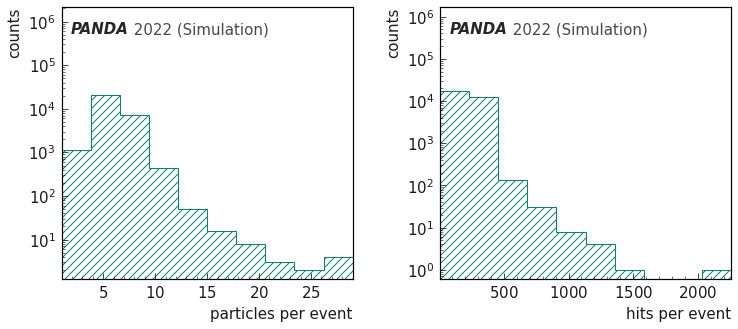

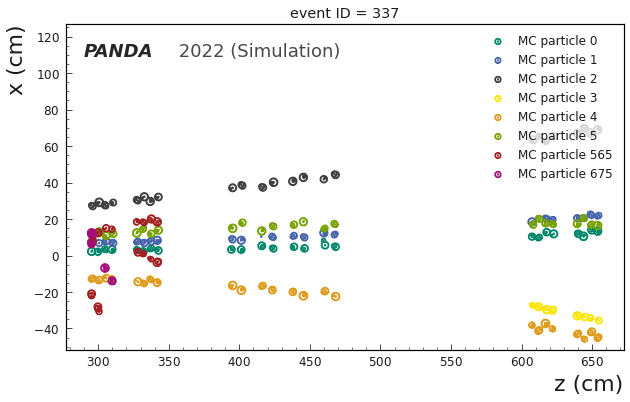

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.44it/s]


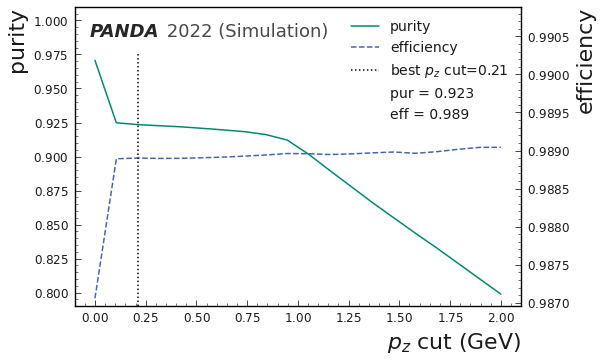

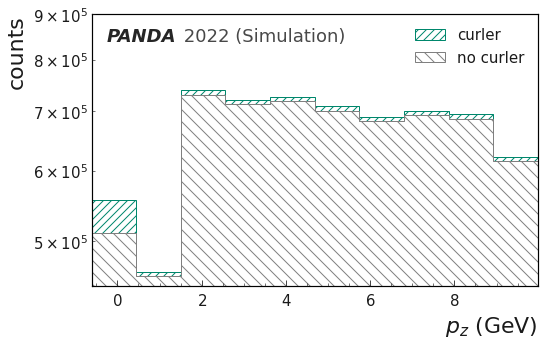

In [4]:
show=True
if show:
   
    plot_information(raw).plot_ntracks_nhits()
    evID=np.random.randint(nevents)
    event = raw.loc[raw.index==evID]
    plot_event(event).plot_eventdisplay()
    
    data_eval = evaluate_data(raw)
    data_eval.plot_pzcut(2)
    data_eval.curler_dist()

# Build graphs

In [5]:
%%time
data = build_graphs(raw,end=nevents, shuffle=True, remove_duplicates=True)
graphs = data.create_graph_list()

#show preprocessed data
data.events.sort_index()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:03<00:00, 262.96it/s]

CPU times: user 3.92 s, sys: 7.61 ms, total: 3.92 s
Wall time: 3.91 s


,hit_id,x,z,iso,pz,chamber_id,skewed,particle_id,layer_id,Hit_id,layer,r,theta
event_id,,,,,,,,,,,,,
0,72394,32.572498,341.390015,0.445295,7.657413,2,0,2,15,114,7,342.940388,0.095123
0,176200,-19.442499,639.869690,0.217349,2.603750,6,0,5,42,9,22,640.165003,-0.030376
0,207025,15.907500,423.839691,0.089051,5.259365,3,0,4,24,45,12,424.138105,0.037514
0,101566,16.412500,466.964996,0.054954,5.260012,4,0,4,31,52,15,467.253334,0.035133
0,180192,28.532499,326.894989,0.075142,3.068103,2,0,1,9,157,5,328.137833,0.087063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,15398,-28.532499,342.264679,0.167747,9.108500,2,0,3,16,72,8,343.451909,-0.083172
1000,79387,-57.317501,621.489990,0.169984,9.069591,5,0,3,39,79,19,624.127474,-0.091966
1000,65797,-66.407501,621.489990,0.424449,0.585620,5,0,4,39,39,19,625.027811,-0.106448


# Evaluate Graph building
for comparison with original raw data choose evaluate_graphs(data.raw.rename(columns={'layer_id':'layer'}), graphs).evaluate_graphs()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.61it/s]


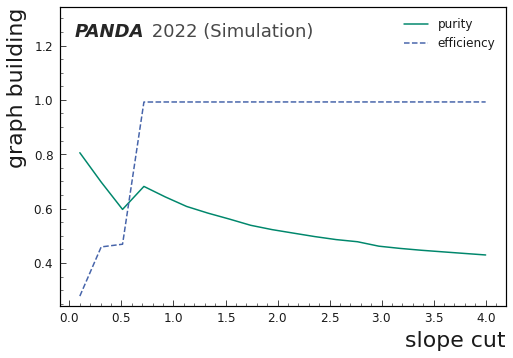

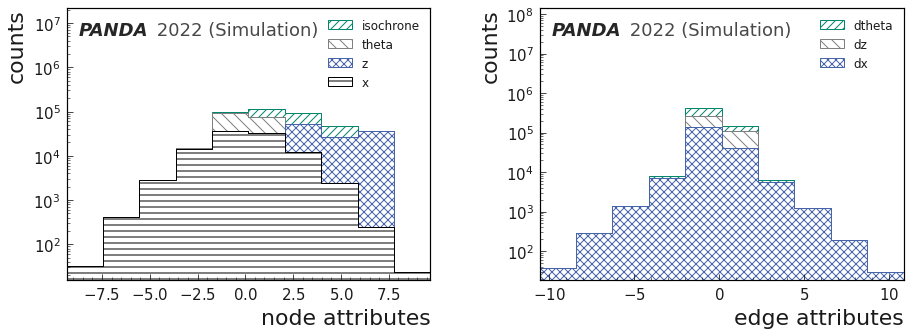

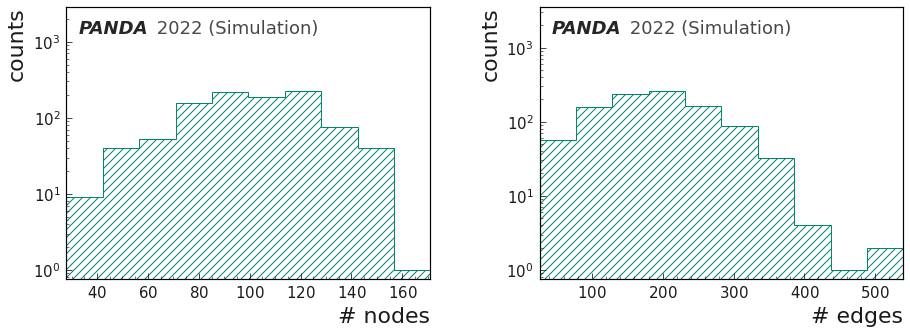

In [6]:
from tqdm import tqdm
slope = np.linspace(0.1,4,20)
testdata = build_graphs(raw,end=100, shuffle=True, remove_duplicates=True)

purities, efficiencies = np.zeros(len(slope)), np.zeros(len(slope))

for i, s in enumerate(tqdm(slope)):
    testdata.slope = s
    testgraphs = testdata.create_graph_list(show_progress=False)
    purity, efficiency, _ = evaluate_graphs(testdata.events, testgraphs).evaluate_graphs(show_progress=False)
    purities[i] = np.mean(purity)
    efficiencies[i] = np.mean(efficiency)

    
plot_information().plot_purity_efficiency(slope, purities, efficiencies, 'slope cut', 'graph building')

plot_information(graphs=graphs).plot_graph_information()

# Plot Graphs

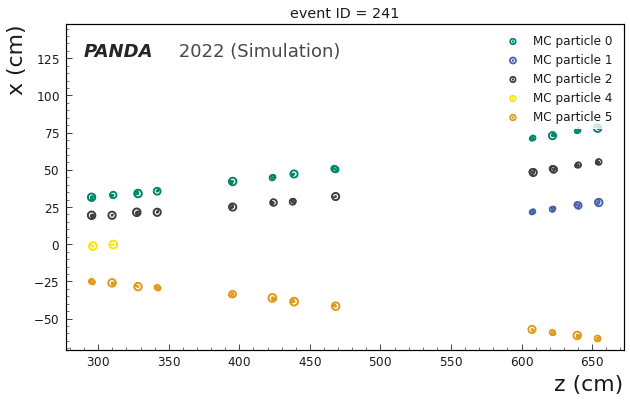

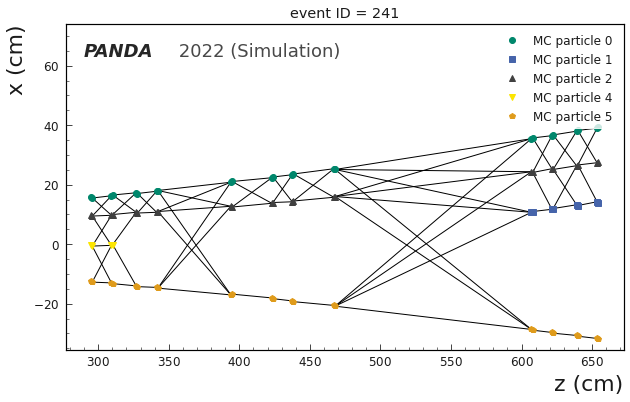

In [7]:
evID = np.random.randint(nevents)

hits = data.events.loc[evID]
graph = graphs[evID]

plot_event(hits).plot_eventdisplay()
plot_event(graph=graph).plot_graphdisplay()



# Prepare Training

In [8]:
torch.manual_seed(42)
device = torch.device('cpu')
hidden_size = 8
lr = 0.01
gamma = 0.7
epochs = 30
patience = 5
parts = [0.8, 0.1, 0.1] #sizes of training, validation and testing samples

parts = np.cumsum((nevents*np.array(parts)).astype(int))
partition = {'train': graphs[:parts[0]],  
             'test':  graphs[parts[0]:parts[1]],
             'val': graphs[parts[1]:parts[2]]}

params = {'batch_size': 1, 'shuffle': True, 'num_workers': 6}
train_set = GraphDataset(partition['train'])
train_loader = DataLoader(train_set, **params)
test_set = GraphDataset(partition['test'])
test_loader = DataLoader(test_set, **params)
val_set = GraphDataset(partition['val'])
val_loader = DataLoader(val_set, **params)

In [9]:
model = InteractionNetwork(node_indim=4, edge_indim=3, node_outdim=4, edge_outdim=3, hidden_size=hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=5, gamma=gamma)
patience = 3
model.count_parameters()

+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |     88     |
|  R1.layers.0.bias  |     8      |
| R1.layers.2.weight |     64     |
|  R1.layers.2.bias  |     8      |
| R1.layers.4.weight |     24     |
|  R1.layers.4.bias  |     3      |
| O.layers.0.weight  |     56     |
|  O.layers.0.bias   |     8      |
| O.layers.2.weight  |     64     |
|  O.layers.2.bias   |     8      |
| O.layers.4.weight  |     32     |
|  O.layers.4.bias   |     4      |
| R2.layers.0.weight |     88     |
|  R2.layers.0.bias  |     8      |
| R2.layers.2.weight |     64     |
|  R2.layers.2.bias  |     8      |
| R2.layers.4.weight |     8      |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 544
InteractionNetwork()


# Training

In [10]:
results = train_model(train_loader, val_loader, test_loader, model, optimizer, scheduler, epochs=epochs, patience=patience)

  0%|                                                                                                                                                                                                                                                    | 0/30 [00:00<?, ?it/s]

Train Epoch: 1, epoch time: 3.93s
Mean Train Batch Loss: 0.2479
TPR = 0.9439252336448598, TNR = 1.0
diff= 0.0093, nbest_disc= 0.2000
mean best disc 0.457


  3%|███████▊                                                                                                                                                                                                                                    | 1/30 [00:05<02:35,  5.37s/it]


Test set: Average loss: 0.0024
, Accuracy: 0.9219

Validation loss decreased (inf --> 0.206450).  Saving model ...
Train Epoch: 2, epoch time: 3.96s
Mean Train Batch Loss: 0.1737
TPR = 0.782608695652174, TNR = 0.9795918367346939
diff= 0.0053, nbest_disc= 0.2800
mean best disc 0.485


  7%|███████████████▋                                                                                                                                                                                                                            | 2/30 [00:10<02:30,  5.38s/it]


Test set: Average loss: 0.0017
, Accuracy: 0.9309

Validation loss decreased (0.206450 --> 0.186396).  Saving model ...
Train Epoch: 3, epoch time: 3.98s
Mean Train Batch Loss: 0.1619
TPR = 0.7333333333333333, TNR = 0.9885057471264368
diff= 0.0087, nbest_disc= 0.4500
mean best disc 0.544


 10%|███████████████████████▌                                                                                                                                                                                                                    | 3/30 [00:16<02:26,  5.42s/it]


Test set: Average loss: 0.0004
, Accuracy: 0.9334

Validation loss decreased (0.186396 --> 0.174071).  Saving model ...
Train Epoch: 4, epoch time: 4.01s
Mean Train Batch Loss: 0.1533
TPR = 0.9565217391304348, TNR = 0.9692307692307692
diff= 0.0127, nbest_disc= 0.6500
mean best disc 0.449


 13%|███████████████████████████████▍                                                                                                                                                                                                            | 4/30 [00:21<02:20,  5.42s/it]


Test set: Average loss: 0.0024
, Accuracy: 0.9327

Validation loss decreased (0.174071 --> 0.173305).  Saving model ...
Train Epoch: 5, epoch time: 3.97s
Mean Train Batch Loss: 0.1502
TPR = 0.8979591836734694, TNR = 1.0
diff= 0.0204, nbest_disc= 0.3500
mean best disc 0.522


 17%|███████████████████████████████████████▎                                                                                                                                                                                                    | 5/30 [00:27<02:15,  5.42s/it]


Test set: Average loss: 0.0004
, Accuracy: 0.9374

Validation loss decreased (0.173305 --> 0.155215).  Saving model ...
Train Epoch: 6, epoch time: 3.88s
Mean Train Batch Loss: 0.1427
TPR = 0.9042553191489362, TNR = 1.0
diff= 0.0057, nbest_disc= 0.4100
mean best disc 0.486


 20%|███████████████████████████████████████████████▏                                                                                                                                                                                            | 6/30 [00:32<02:09,  5.39s/it]


Test set: Average loss: 0.0003
, Accuracy: 0.9409

Validation loss decreased (0.155215 --> 0.152499).  Saving model ...
Train Epoch: 7, epoch time: 3.98s
Mean Train Batch Loss: 0.1387
TPR = 0.7898550724637681, TNR = 0.9619047619047619
diff= 0.0014, nbest_disc= 0.6000
mean best disc 0.480


 23%|███████████████████████████████████████████████████████                                                                                                                                                                                     | 7/30 [00:37<02:04,  5.40s/it]


Test set: Average loss: 0.0014
, Accuracy: 0.9381

Validation loss decreased (0.152499 --> 0.151187).  Saving model ...
Train Epoch: 8, epoch time: 3.96s
Mean Train Batch Loss: 0.1389
TPR = 0.8333333333333334, TNR = 1.0
diff= 0.0000, nbest_disc= 0.2000
mean best disc 0.529


 27%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                             | 8/30 [00:43<01:59,  5.41s/it]


Test set: Average loss: 0.0008
, Accuracy: 0.9232

EarlyStopping counter: 1 out of 3
Train Epoch: 9, epoch time: 4.00s
Mean Train Batch Loss: 0.1366
TPR = 0.8936170212765957, TNR = 1.0
diff= 0.0057, nbest_disc= 0.3300
mean best disc 0.410


 30%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 9/30 [00:48<01:53,  5.42s/it]


Test set: Average loss: 0.0008
, Accuracy: 0.9368

EarlyStopping counter: 2 out of 3
Train Epoch: 10, epoch time: 3.98s
Mean Train Batch Loss: 0.1379
TPR = 0.9577464788732394, TNR = 1.0
diff= 0.0000, nbest_disc= 0.3200
mean best disc 0.513


 30%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 9/30 [00:54<02:06,  6.01s/it]


Test set: Average loss: 0.0005
, Accuracy: 0.9377

EarlyStopping counter: 3 out of 3
Early stopping


In [11]:
model, losses, accs, disc, test_losses, test_accs = results.trained

# Evaluate Training

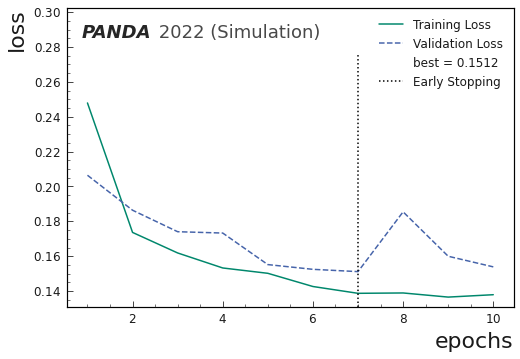

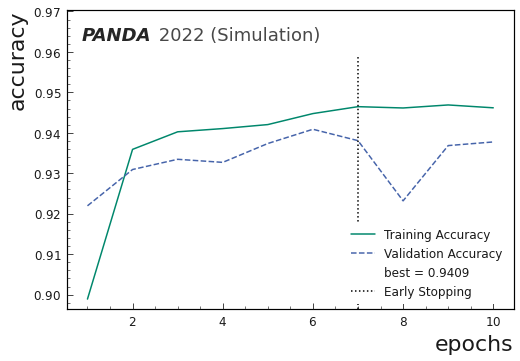

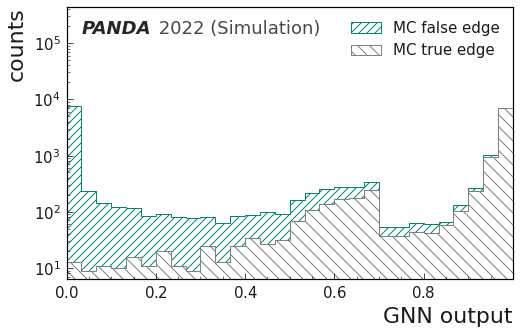

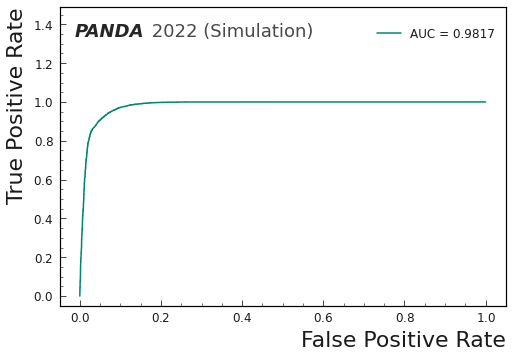

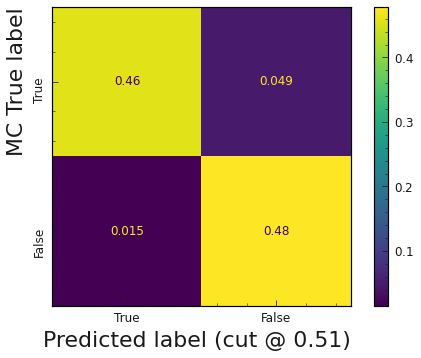

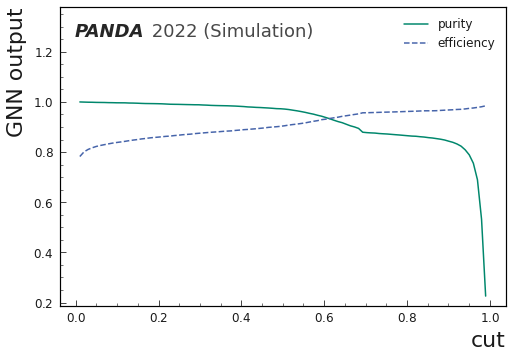

In [12]:
evaluation = evaluate_model('cpu', model, test_loader, losses, test_losses, accs, test_accs, disc, ncuts=100)
evaluation.plot_loss()
evaluation.plot_acc()
evaluation.plot_metrics()

# Show Results

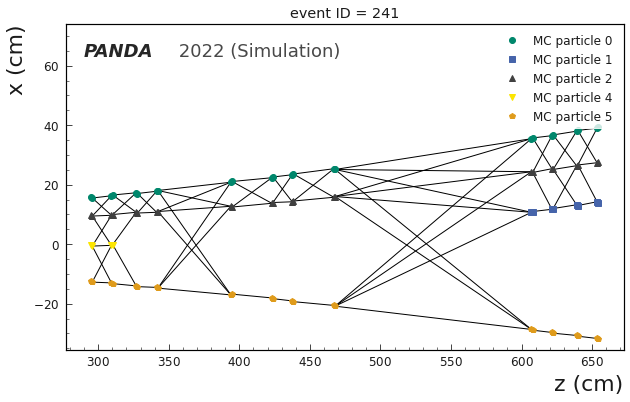

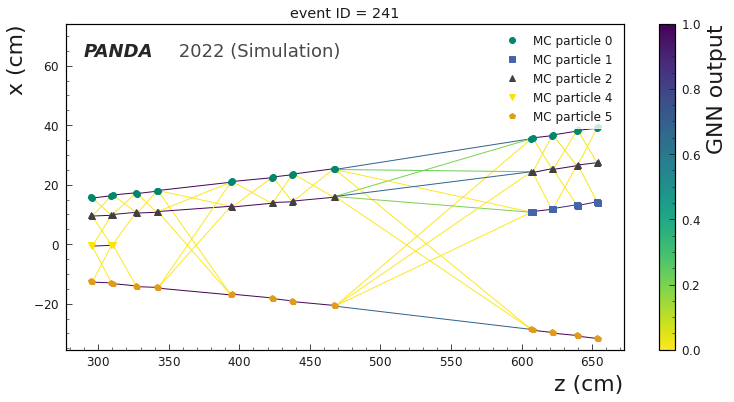

In [13]:
plot_event(hits, graph).plot_graphdisplay()
plot_event(hits, graph).plot_traineddisplay(model)